In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Load stock market data
stock_symbol = "TSLA"
data = yf.download(stock_symbol, start="2015-01-01", end="2025-01-01")
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Add features
data['Moving_Avg_10'] = data['Close'].rolling(window=10).mean()
data['Moving_Avg_50'] = data['Close'].rolling(window=50).mean()
data['Daily_Return'] = data['Close'].pct_change()

# Create target: 1 for "price up", 0 for "price down"
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

# Drop NaN rows created by moving averages
data = data.dropna()

# Features and target
X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Moving_Avg_10', 'Moving_Avg_50', 'Daily_Return']]
y = data['Target']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Check for class balance
print(f"Class Distribution: {np.bincount(y)}")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


[*********************100%***********************]  1 of 1 completed

Class Distribution: [1186 1281]


In [2]:
from imblearn.over_sampling import SMOTE

# Check for imbalance
print("Before Resampling:")
print(f"Class 0: {sum(y_train == 0)}, Class 1: {sum(y_train == 1)}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After Resampling:")
print(f"Class 0: {sum(y_train_resampled == 0)}, Class 1: {sum(y_train_resampled == 1)}")


Before Resampling:
Class 0: 949, Class 1: 1024
After Resampling:
Class 0: 1024, Class 1: 1024


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on the test set
rf_predictions = rf_model.predict(X_test)

# Metrics
print("Random Forest Classifier Results:")
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.2f}")


Random Forest Classifier Results:
[[118 119]
 [118 139]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       237
           1       0.54      0.54      0.54       257

    accuracy                           0.52       494
   macro avg       0.52      0.52      0.52       494
weighted avg       0.52      0.52      0.52       494

ROC-AUC Score: 0.53


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build Neural Network
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Neural Network Test Accuracy: {nn_accuracy:.2f}")


Epoch 1/50


/opt/miniconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4942 - loss: 0.6956 - val_accuracy: 0.4879 - val_loss: 0.6935
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5031 - loss: 0.6942 - val_accuracy: 0.4838 - val_loss: 0.6945
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.5290 - loss: 0.6926 - val_accuracy: 0.5223 - val_loss: 0.6926
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.5220 - loss: 0.6931 - val_accuracy: 0.4798 - val_loss: 0.6952
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5088 - loss: 0.6930 - val_accuracy: 0.4858 - val_loss: 0.6935
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5205 - loss: 0.6924 - val_accuracy: 0.5283 - val_loss: 0.6927
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4839 - loss: 0.6934 - val_accuracy: 0.4960 - val_loss: 0.6931
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.5249 - loss: 0.6919 - val_accuracy: 0.5081 - val_loss: 0.69

In [5]:
# Predict with Neural Network
nn_predictions = (nn_model.predict(X_test) > 0.5).astype(int)

# Metrics
print("Neural Network Results:")
print(confusion_matrix(y_test, nn_predictions))
print(classification_report(y_test, nn_predictions))
print(f"ROC-AUC Score: {roc_auc_score(y_test, nn_model.predict(X_test)):.2f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Neural Network Results:
[[138  99]
 [147 110]]
              precision    recall  f1-score   support

           0       0.48      0.58      0.53       237
           1       0.53      0.43      0.47       257

    accuracy                           0.50       494
   macro avg       0.51      0.51      0.50       494
weighted avg       0.51      0.50      0.50       494

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
ROC-AUC Score: 0.52


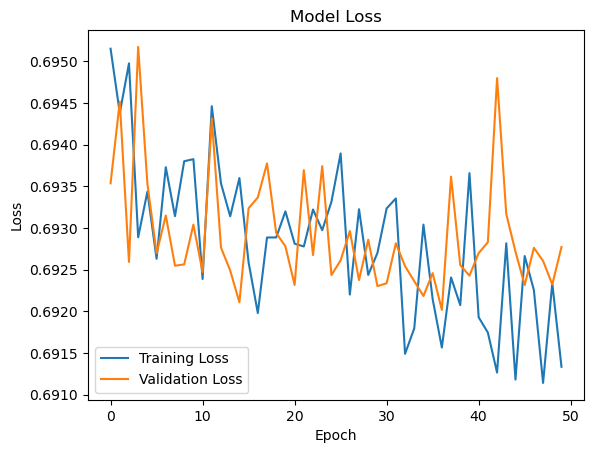

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
